In [1]:
from deeppavlov.core.commands.train import build_model_from_config
import json
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pickle

%matplotlib inline

/home/yurakuratov/anaconda3/envs/dp/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     /home/yurakuratov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yurakuratov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2018-05-10 18:04:37.219 DEBUG in 'gensim.models.doc2vec'['doc2vec'] at line 73: Fast version of gensim.models.doc2vec is being used
2018-05-10 18:04:37.222 INFO in 'summa.preprocessing.cleaner'['textcleaner'] at line 20: 'pattern' package not found; tag filters are not available for English


INFO:tensorflow:Restoring parameters from /home/yurakuratov/data/DeepPavlov/download/squad_model/model


In [2]:
model = build_model_from_config(json.load(open('/media/olga/Data/projects/iPavlov/DeepPavlov/deeppavlov/configs/squad/squad.json', 'r')))

2018-05-10 18:04:37.767 INFO in 'deeppavlov.models.preprocessors.squad_preprocessor'['squad_preprocessor'] at line 254: SquadVocabEmbedder: loading saved tokens vocab from /home/yurakuratov/data/DeepPavlov/download/squad_model/emb/vocab_embedder.pckl
2018-05-10 18:04:37.927 INFO in 'deeppavlov.models.preprocessors.squad_preprocessor'['squad_preprocessor'] at line 254: SquadVocabEmbedder: loading saved chars vocab from /home/yurakuratov/data/DeepPavlov/download/squad_model/emb/char_vocab_embedder.pckl
2018-05-10 18:04:40.936 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 40: [loading model from /home/yurakuratov/data/DeepPavlov/download/squad_model/model]
2018-05-10 18:04:40.982 INFO in 'tensorflow'['tf_logging'] at line 82: Restoring parameters from /home/yurakuratov/data/DeepPavlov/download/squad_model/model


In [3]:
model([('Pavlov killed Kenny', 'Who killed Kenny?')])

[('Pavlov', 0, 0.9995623230934143)]

In [4]:
qas = {}
with open('qa_to_photo_toloka_revised.tsv', 'r') as fin:
    fin.readline()
    for line in fin:
        q, a = line.rstrip().split('\t')
        qas[q] = a

In [5]:
data = pickle.load(open('drones_sentence_ranking.pkl', 'rb'))

In [26]:
ems = []
f1s = []
thrs = []
for thr in tqdm(np.linspace(0, 0.8, 11)):
    true_ans = []
    pred_ans = []
    for q, sentences in data:
        true_ans.append(([qas[q]], [-1]))
        context = ''
        for s, sent in sentences:
            if s >= thr:
                context += ' ' + sent
            else:
                break
        
        if len(context) > 0:
            a, p, s = model([(context, q)])[0]
            pred_ans.append((a, p))
        else:
            pred_ans.append(('<NO_ANS>', -1))
    em = exact_match(true_ans, pred_ans)
    f1 = squad_f1(true_ans, pred_ans)
    thrs.append(thr)
    ems.append(em)
    f1s.append(f1)
plt.plot(thrs, ems)
plt.plot(thrs, f1s)
plt.show()

A Jupyter Widget

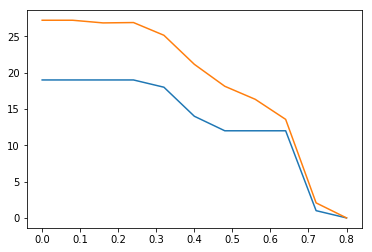

In [29]:
# 2000 context
plt.plot(thrs, ems)
plt.plot(thrs, f1s)
plt.show()

A Jupyter Widget

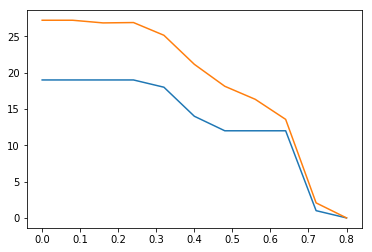

In [8]:
# 4000 context

A Jupyter Widget

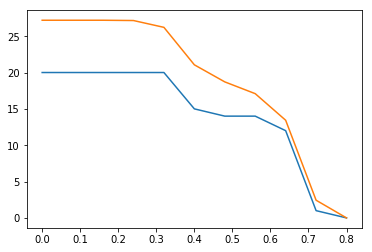

In [7]:
# 100 context

A Jupyter Widget

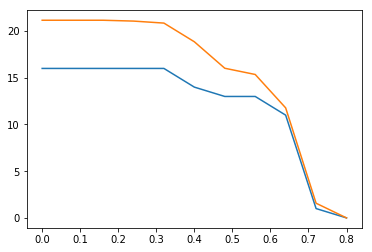

In [8]:
import random
for thr in [0.0]:
    true_ans = []
    pred_ans = []
    for q, sentences in tqdm(data):
        true_ans.append(([qas[q]], [-1]))
        context = ''
        random.shuffle(sentences)
        for s, sent in sentences:
            if s >= thr:
                context += ' ' + sent
            else:
                break
        
        if len(context) > 0:
            a, p, s = model([(context, q)])[0]
            pred_ans.append((a, p))
        else:
            pred_ans.append(('<NO_ANS>', -1))
    em = exact_match(true_ans, pred_ans)
    f1 = squad_f1(true_ans, pred_ans)
    print(em, f1)

A Jupyter Widget


8.0 11.771319882897041


In [34]:
drones_text = ''
with open('Drones.txt', 'r') as fin:
    for line in fin:
        drones_text += ' ' + line.strip()

In [35]:
for thr in [0.0]:
    true_ans = []
    pred_ans = []
    for q, sentences in tqdm(data):
        true_ans.append(([qas[q]], [-1]))
        context = drones_text
        if len(context) > 0:
            a, p, s = model([(context, q)])[0]
            pred_ans.append((a, p))
        else:
            pred_ans.append(('<NO_ANS>', -1))
    em = exact_match(true_ans, pred_ans)
    f1 = squad_f1(true_ans, pred_ans)
    print(em, f1)

A Jupyter Widget


17.0 28.296219793233387


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f284039da58>]], dtype=object)

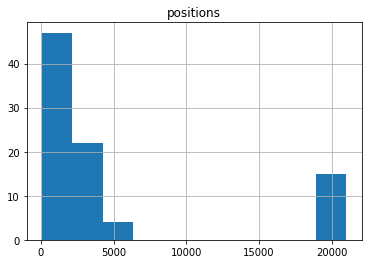

In [32]:
positions = []
for q, a in qas.items():
    positions.append(drones_text.lower().rfind(a.lower(), ))
import pandas as pd
df = pd.DataFrame()
df['positions'] = positions
df.hist()

In [6]:
import re
import string
from collections import Counter

def exact_match(y_true, y_predicted):
    """ Calculates Exact Match score between y_true and y_predicted
        EM score uses the best matching y_true answer:
            if y_pred equal at least to one answer in y_true then EM = 1, else EM = 0

    Args:
        y_true: list of tuples (y_true_text, y_true_start), y_true_text and y_true_start are lists of len num_answers
        y_predicted: list of tuples (y_pred_text, y_pred_start), y_pred_text : str, y_pred_start : int

    Returns:
        exact match score : float
    """
    EM_total = 0
    count = 0
    for ground_truth, prediction in zip(y_true, y_predicted):
        if len(ground_truth[0][0]) == 0:
            # skip empty answers
            continue
        count += 1
        ground_truth = ground_truth[0]
        prediction = prediction[0]
        EMs = [int(normalize_answer(gt) == normalize_answer(prediction)) for gt in ground_truth]
        EM_total += max(EMs)
    return 100 * EM_total / count if count > 0 else 0

def squad_f1(y_true, y_predicted):
    """ Calculates F-1 score between y_true and y_predicted
        F-1 score uses the best matching y_true answer

    Args:
        y_true: list of tuples (y_true_text, y_true_start), y_true_text and y_true_start are lists of len num_answers
        y_predicted: list of tuples (y_pred_text, y_pred_start), y_pred_text : str, y_pred_start : int

    Returns:
        F-1 score : float
    """
    f1_total = 0.0
    count = 0
    for ground_truth, prediction in zip(y_true, y_predicted):
        if len(ground_truth[0][0]) == 0:
            continue
        count += 1
        ground_truth = ground_truth[0]
        prediction = prediction[0]
        prediction_tokens = normalize_answer(prediction).split()
        f1s = []
        for gt in ground_truth:
            gt_tokens = normalize_answer(gt).split()
            common = Counter(prediction_tokens) & Counter(gt_tokens)
            num_same = sum(common.values())
            if num_same == 0:
                f1s.append(0.0)
                continue
            precision = 1.0 * num_same / len(prediction_tokens)
            recall = 1.0 * num_same / len(gt_tokens)
            f1 = (2 * precision * recall) / (precision + recall)
            f1s.append(f1)
        f1_total += max(f1s)
    return 100 * f1_total / count if count > 0 else 0


def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))